<a href="https://colab.research.google.com/github/semesarker/A-Dilated-Attention-U-Net-Based-Approach-on-Speech-Emotion-Recognition/blob/main/Unet_GRU_model_on_BanglaSER_using_feature_concatenation(mfcc%26mel_spectrogram).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/THSIS/banglaSER/bangla-ser-database.zip'

Archive:  /content/drive/MyDrive/THSIS/banglaSER/bangla-ser-database.zip
  inflating: t9h6p943xy-5/BanglaSER/Actor 01/03-01-01-01-02-02-01.wav  
  inflating: t9h6p943xy-5/BanglaSER/Actor 01/03-01-02-01-01-01-01.wav  
  inflating: t9h6p943xy-5/BanglaSER/Actor 01/03-01-01-01-01-03-01.wav  
  inflating: t9h6p943xy-5/BanglaSER/Actor 01/03-01-01-01-02-03-01.wav  
  inflating: t9h6p943xy-5/BanglaSER/Actor 01/03-01-01-01-01-02-01.wav  
  inflating: t9h6p943xy-5/BanglaSER/Actor 01/03-01-01-01-03-02-01.wav  
  inflating: t9h6p943xy-5/BanglaSER/Actor 01/03-01-01-01-02-01-01.wav  
  inflating: t9h6p943xy-5/BanglaSER/Actor 01/03-01-01-01-03-03-01.wav  
  inflating: t9h6p943xy-5/BanglaSER/Actor 01/03-01-01-01-01-01-01.wav  
  inflating: t9h6p943xy-5/BanglaSER/Actor 01/03-01-01-01-03-01-01.wav  
  inflating: t9h6p943xy-5/BanglaSER/Actor 01/03-01-02-01-01-02-01.wav  
  inflating: t9h6p943xy-5/BanglaSER/Actor 01/03-01-02-01-01-03-01.wav  
  inflating: t9h6p943xy-5/BanglaSER/Actor 01/03-01-02-01-02-01-

In [ ]:
# Keras
#import tensorflow as tf
import IPython
import keras
from keras import regularizers

from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D,Conv2D,MaxPool2D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Conv2D,Conv2DTranspose, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer


# from keras_preprocessing.sequence import pad_sequences


# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Other
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob
import os
import sys
import IPython.display as Audio  # To play sound in the notebook
import warnings

import numpy as np # linear algebra
import pandas as pd
from tqdm import tqdm
from glob import glob
from keras.layers import *
from keras.models import *
from keras.utils import *
import numpy as np
import os
from tensorflow.keras.optimizers import Adam

# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
banglaSER = "/content/t9h6p943xy-5/BanglaSER"
banglaSER_directory_list = os.listdir(banglaSER)
banglaSER_directory_list

['Actor 12',
 'Actor 17',
 'Actor 10',
 'Actor 29',
 'Actor 01',
 'Actor 04',
 'Actor 24',
 'Actor 27',
 'Actor 14',
 'Actor 28',
 'Actor 30',
 'Actor 06',
 'Actor 13',
 'Actor 22',
 'Actor 02',
 'Actor 20',
 'Actor 11',
 'Actor 16',
 'Actor 34',
 'Actor 21',
 'Actor 33',
 'Actor 15',
 'Actor 32',
 'Actor 03',
 'Actor 05',
 'Actor 23',
 'Actor 08',
 'Actor 18',
 'Actor 19',
 'Actor 07',
 'Actor 09',
 'Actor 31',
 'Actor 25',
 'Actor 26']

In [ ]:
a=list()
b=list()
c=list()
# Ravdess preprocess
banglaSER_directory_list = os.listdir(banglaSER)
file_path = []
file_emotion = []
for directory in banglaSER_directory_list:
    # 24 different actors in Ravdess directory needed to be extracted as files for each actor
    actor = os.listdir(banglaSER + '/' + directory)
    for file in actor:
        part1 = file.split('.')[0]
        # print(part1)
        part2 = part1.split('-')
        # print(part2)
        # third part in each file represents the emotion associated to that file
        file_emotion.append(int(part2[2]))
        file_path.append(banglaSER + '/' + directory + '/' + file)

        a.append(banglaSER +'/'+ directory +'/'+file)
        b.append(part1)
        c.append(part2)

In [ ]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])
banglaSER_df = pd.concat([emotion_df, path_df], axis=1)
# decode integers to actual emotions
banglaSER_df.Emotions.replace({1:'angry', 2:'happy', 3:'neutral', 4:'sad', 5:'surprise'}, inplace=True)
banglaSER_df.head()

,Emotions,Path
0,sad,/content/t9h6p943xy-5/BanglaSER/Actor 12/03-01...
1,happy,/content/t9h6p943xy-5/BanglaSER/Actor 12/03-01...
2,neutral,/content/t9h6p943xy-5/BanglaSER/Actor 12/03-01...
3,happy,/content/t9h6p943xy-5/BanglaSER/Actor 12/03-01...
4,neutral,/content/t9h6p943xy-5/BanglaSER/Actor 12/03-01...


In [ ]:
banglaSER_df.shape

(1467, 2)

In [ ]:
banglaSER_df.Emotions.value_counts()

sad         306
happy       306
neutral     306
angry       306
surprise    243
Name: Emotions, dtype: int64

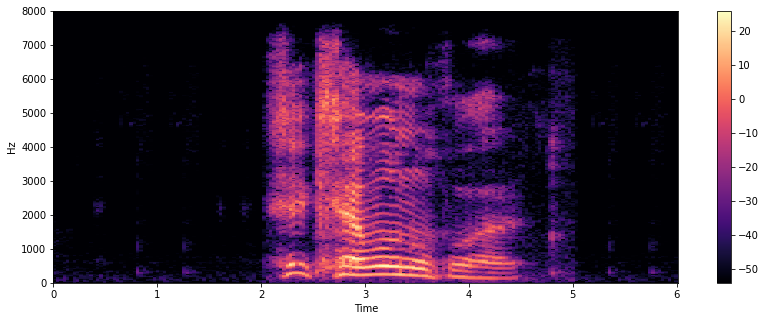

In [ ]:
emotion='angry'
path = np.array(banglaSER_df.Path[banglaSER_df.Emotions==emotion])[30]
data, sr = librosa.load(path,sr=16000, duration=3)
st_data = np.abs(librosa.stft(data,n_fft=512,hop_length=256,win_length=512))
st_db = librosa.amplitude_to_db(st_data)
plt.figure(figsize=(14, 5))
librosa.display.specshow(st_db, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar()

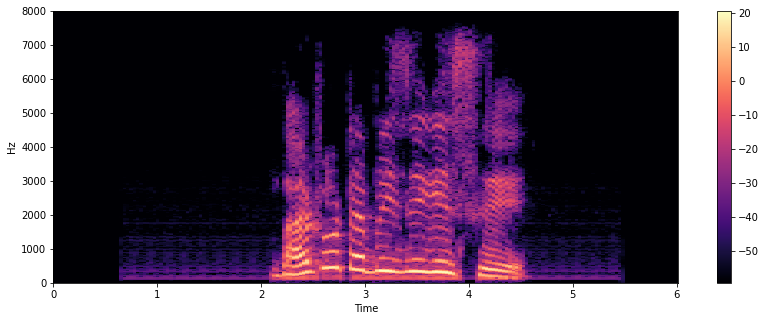

In [ ]:
emotion='sad'
path = np.array(banglaSER_df.Path[banglaSER_df.Emotions==emotion])[50]
data, sr = librosa.load(path,sr=16000, duration=3)
st_data = np.abs(librosa.stft(data,n_fft=512,hop_length=256,win_length=512))
st_db = librosa.amplitude_to_db(st_data)
plt.figure(figsize=(14, 5))
librosa.display.specshow(st_db, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar()

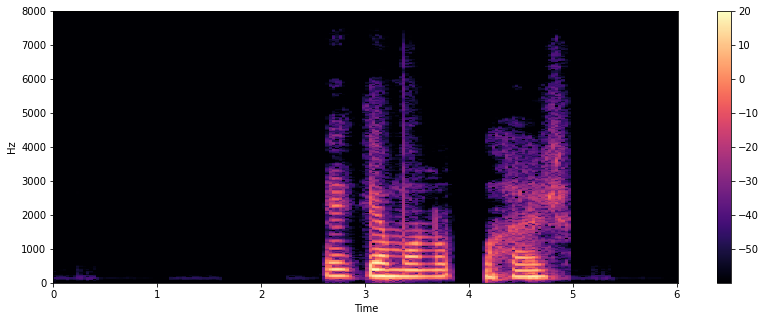

In [ ]:
emotion='surprise'
path = np.array(banglaSER_df.Path[banglaSER_df.Emotions==emotion])[30]
data, sr = librosa.load(path,sr=16000, duration=3)
st_data = np.abs(librosa.stft(data,n_fft=512,hop_length=256,win_length=512))
st_db = librosa.amplitude_to_db(st_data)
plt.figure(figsize=(14, 5))
librosa.display.specshow(st_db, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar()

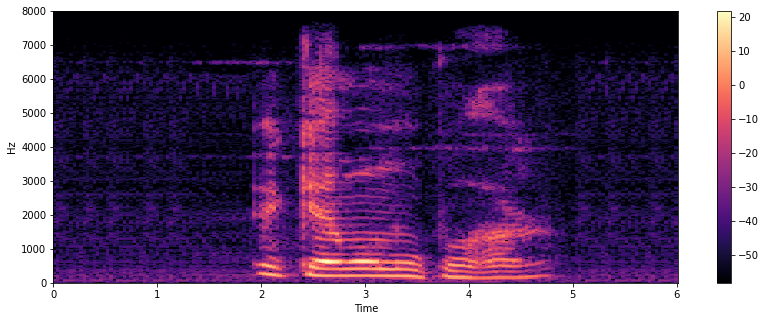

In [ ]:
emotion='happy'
path = np.array(banglaSER_df.Path[banglaSER_df.Emotions==emotion])[30]
data, sr = librosa.load(path,sr=16000, duration=3)
st_data = np.abs(librosa.stft(data,n_fft=512,hop_length=256,win_length=512))
st_db = librosa.amplitude_to_db(st_data)
plt.figure(figsize=(14, 5))
librosa.display.specshow(st_db, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar()

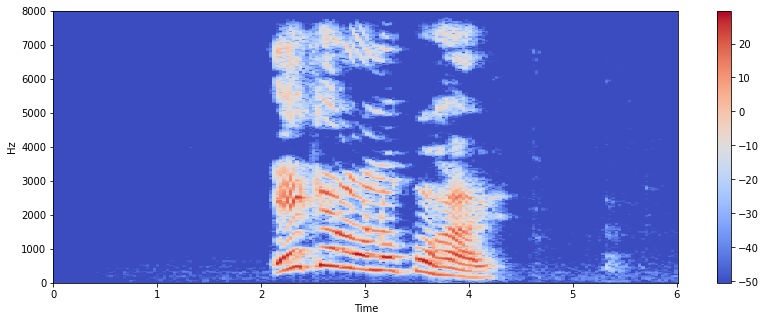

In [ ]:
emotion='neutral'
path = np.array(banglaSER_df.Path[banglaSER_df.Emotions==emotion])[50]
data, sr = librosa.load(path,sr=16000, duration=3)
st_data = np.abs(librosa.stft(data,n_fft=512,hop_length=256,win_length=512))
st_db = librosa.amplitude_to_db(st_data)
plt.figure(figsize=(14, 5))
librosa.display.specshow(st_db, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar()

In [ ]:
def create_mel_spectrogram(data, sr, e):
    mel_signal = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=30)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    plt.figure(figsize=(12, 3))
    plt.title('Mel-Spectrogram for {}'.format(e), size=15)
    librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar()

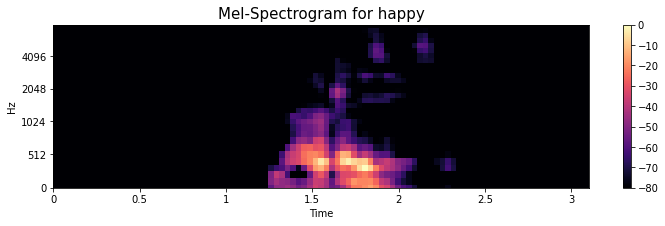

In [ ]:
emotion='happy'
path = np.array(banglaSER_df.Path[banglaSER_df.Emotions==emotion])[40]
data, sr = librosa.load(path,sr=16000, duration=4)
mel_spectrogram=librosa.feature.melspectrogram(data,sr=sr,n_mels=30)
log_mel_spectrogram=librosa.amplitude_to_db(mel_spectrogram, ref=np.max)
create_mel_spectrogram(data,sr,emotion)

In [ ]:
# Method 3
import scipy
from scipy.io import wavfile
sample_rate= 16000
# function to convert the information into
# some readable format
def output_duration(length):
	hours = length // 3600 # calculate in hours
	length %= 3600
	mins = length // 60 # calculate in minutes
	length %= 60
	seconds = length # calculate in seconds

	return hours, mins, seconds

# sample_rate holds the sample rate of the wav file
# in (sample/sec) format
# data is the numpy array that consists
# of actual data read from the wav file
count = 0
for r in np.array(banglaSER_df.Path):
  sample_rate, data = wavfile.read(r)

  len_data = len(data) # holds length of the numpy array

  t = len_data / sample_rate # returns duration but in floats

  hours, mins, seconds = output_duration(int(t))
  print('Total Duration: {}:{}:{}'.format(hours, mins, seconds))
  count= count+1
print(count)

Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Dura

<ipython-input-16-198e09f56db4>:22: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(r)


Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Duration: 0:0:3
Total Dura

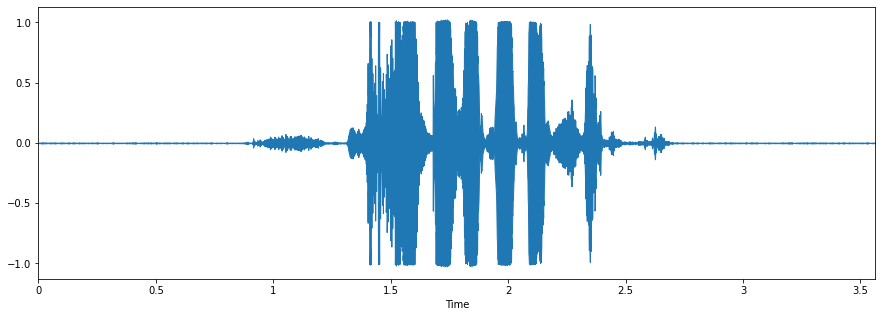

In [ ]:
# Use one audio file in previous parts again
fname = file_path[0]
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Paly it again to refresh our memory
IPython.display.Audio(data, rate=sampling_rate)

In [ ]:
def match_dimension(data,input_length):

  if len(data) > input_length:
      max_offset = int(len(data) - input_length)
      data = data[0:input_length]
  else:
      max_offset =int(input_length - len(data))
      offset = np.zeros(max_offset)
      data=np.concatenate((data,offset),axis=0)

  return data

In [ ]:
sampling_rate=16000
audio_duration=3
n_mfcc = 30
n_melspec = 30
n_fft=512
def prepare_data(df, n, mfcc ,mel):
    X = np.empty(shape=(df.shape[0], n,94,1))
    input_length = sampling_rate * audio_duration

    cnt = 0
    for fname in tqdm(df.Path):
        file_path = fname
        data, sr = librosa.load(file_path, sr=sampling_rate

                               ,duration=3

                              )

        if len(data)!= input_length:

        # Random offset / Padding
            data=match_dimension(data,48000)




          # which feature?
          # if mfcc == 1:
          #       # MFCC extraction
          #   MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
          #   MFCC = np.expand_dims(MFCC, axis=-1)
          #   X[cnt,] = MFCC
          #   print('mfcc',MFCC.shape)

        if mfcc == 1 and mel== 0:
                  # MFCC extraction
              MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
              MFCC = np.expand_dims(MFCC, axis=-1)
              X[cnt,] = MFCC
              print('mfcc',MFCC.shape)

        elif mfcc==0 and mel==1 :
                  # Log-melspectogram

              melspec = librosa.feature.melspectrogram(data,sr=sampling_rate, n_mels = n_melspec)
              mel_spectrogram = np.abs(melspec)
              logspec = librosa.amplitude_to_db(mel_spectrogram)
              logspec = np.expand_dims(logspec, axis=-1)
              X[cnt,] = logspec

              print('mel',logspec.shape)

        elif mfcc==1 and mel== 1:
              MFCC = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=n_mfcc)
              melspec = librosa.feature.melspectrogram(data,sr=sampling_rate, n_mels = n_melspec)
              mel_spectrogram = np.abs(melspec)
              logspec = librosa.amplitude_to_db(mel_spectrogram)
              mfcc_logspec= np.concatenate((MFCC,logspec),axis=0)
              #mel_logspec= np.vstack([MFCC,logspec])
              #print(mfcc_logspec.shape)
              mfcc_logspec = np.expand_dims(mfcc_logspec, axis=-1)
              X[cnt,] = mfcc_logspec
              print('mfcc_logspec',mfcc_logspec.shape)

        cnt += 1

    return X

In [ ]:
mel_mfcc = prepare_data(banglaSER_df,n=60,mfcc=1,mel=1)

  0%|          | 2/1467 [00:00<03:53,  6.27it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  0%|          | 4/1467 [00:00<03:37,  6.74it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  0%|          | 6/1467 [00:00<03:29,  6.97it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  1%|          | 8/1467 [00:01<03:26,  7.05it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  1%|          | 10/1467 [00:01<03:25,  7.10it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  1%|          | 12/1467 [00:01<03:26,  7.05it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  1%|          | 14/1467 [00:02<03:24,  7.10it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  1%|          | 16/1467 [00:02<03:22,  7.15it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  1%|          | 18/1467 [00:02<03:20,  7.24it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  1%|▏         | 20/1467 [00:02<03:25,  7.04it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  1%|▏         | 22/1467 [00:03<03:26,  7.01it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  2%|▏         | 23/1467 [00:03<03:34,  6.75it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 24/1467 [00:03<04:16,  5.63it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 26/1467 [00:04<04:48,  4.99it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  2%|▏         | 28/1467 [00:04<04:06,  5.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  2%|▏         | 30/1467 [00:04<03:47,  6.32it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  2%|▏         | 32/1467 [00:04<03:44,  6.40it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  2%|▏         | 34/1467 [00:05<03:33,  6.71it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  2%|▏         | 36/1467 [00:05<03:27,  6.88it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  3%|▎         | 38/1467 [00:05<03:56,  6.05it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  3%|▎         | 40/1467 [00:06<04:03,  5.87it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  3%|▎         | 42/1467 [00:06<04:08,  5.73it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  3%|▎         | 44/1467 [00:06<04:09,  5.70it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  3%|▎         | 46/1467 [00:07<04:16,  5.55it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  3%|▎         | 48/1467 [00:07<04:13,  5.60it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  3%|▎         | 50/1467 [00:07<04:15,  5.55it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  4%|▎         | 52/1467 [00:08<04:12,  5.61it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  4%|▎         | 54/1467 [00:08<04:12,  5.59it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  4%|▍         | 56/1467 [00:09<04:17,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  4%|▍         | 58/1467 [00:09<04:12,  5.58it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  4%|▍         | 60/1467 [00:09<04:14,  5.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  4%|▍         | 62/1467 [00:10<04:12,  5.57it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  4%|▍         | 64/1467 [00:10<04:16,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  4%|▍         | 66/1467 [00:10<04:16,  5.46it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  5%|▍         | 68/1467 [00:11<04:13,  5.52it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  5%|▍         | 70/1467 [00:11<04:10,  5.58it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  5%|▍         | 72/1467 [00:11<04:10,  5.57it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  5%|▌         | 74/1467 [00:12<04:15,  5.46it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  5%|▌         | 76/1467 [00:12<04:13,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  5%|▌         | 78/1467 [00:13<04:16,  5.42it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  5%|▌         | 80/1467 [00:13<04:14,  5.46it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  6%|▌         | 82/1467 [00:13<03:57,  5.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  6%|▌         | 84/1467 [00:14<03:53,  5.92it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  6%|▌         | 86/1467 [00:14<03:31,  6.52it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  6%|▌         | 88/1467 [00:14<03:32,  6.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  6%|▌         | 90/1467 [00:14<03:31,  6.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  6%|▌         | 91/1467 [00:15<03:29,  6.56it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 93/1467 [00:15<06:01,  3.80it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  6%|▋         | 95/1467 [00:16<04:53,  4.68it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  7%|▋         | 96/1467 [00:16<05:23,  4.23it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 98/1467 [00:17<05:51,  3.90it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  7%|▋         | 100/1467 [00:17<04:30,  5.06it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  7%|▋         | 101/1467 [00:17<04:49,  4.72it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 103/1467 [00:18<05:37,  4.04it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  7%|▋         | 105/1467 [00:18<04:32,  5.00it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  7%|▋         | 107/1467 [00:18<03:54,  5.81it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  7%|▋         | 109/1467 [00:19<03:32,  6.38it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  8%|▊         | 111/1467 [00:19<03:34,  6.31it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  8%|▊         | 113/1467 [00:19<03:25,  6.59it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  8%|▊         | 115/1467 [00:20<03:35,  6.27it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  8%|▊         | 117/1467 [00:20<03:28,  6.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  8%|▊         | 119/1467 [00:20<03:19,  6.75it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  8%|▊         | 121/1467 [00:21<03:18,  6.80it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  8%|▊         | 123/1467 [00:21<03:33,  6.31it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  9%|▊         | 125/1467 [00:21<03:21,  6.65it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  9%|▊         | 127/1467 [00:21<03:16,  6.83it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  9%|▉         | 129/1467 [00:22<03:14,  6.88it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  9%|▉         | 131/1467 [00:22<03:11,  6.96it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  9%|▉         | 133/1467 [00:22<03:08,  7.07it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  9%|▉         | 135/1467 [00:23<03:06,  7.13it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  9%|▉         | 137/1467 [00:23<03:13,  6.89it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


  9%|▉         | 139/1467 [00:23<03:06,  7.12it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 10%|▉         | 141/1467 [00:23<03:05,  7.17it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 10%|▉         | 143/1467 [00:24<03:04,  7.16it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 10%|▉         | 145/1467 [00:24<03:08,  7.02it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 10%|█         | 147/1467 [00:24<03:05,  7.12it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 10%|█         | 149/1467 [00:25<03:05,  7.09it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 10%|█         | 151/1467 [00:25<03:09,  6.94it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 10%|█         | 153/1467 [00:25<03:09,  6.93it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 11%|█         | 155/1467 [00:25<03:06,  7.02it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 11%|█         | 157/1467 [00:26<03:05,  7.07it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 11%|█         | 159/1467 [00:26<03:10,  6.87it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 11%|█         | 161/1467 [00:26<03:03,  7.12it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 11%|█         | 163/1467 [00:27<03:01,  7.18it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 11%|█         | 165/1467 [00:27<03:00,  7.21it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 11%|█▏        | 167/1467 [00:27<03:04,  7.05it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 12%|█▏        | 169/1467 [00:27<03:04,  7.04it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 12%|█▏        | 171/1467 [00:28<03:02,  7.10it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 12%|█▏        | 173/1467 [00:28<03:05,  6.99it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 12%|█▏        | 175/1467 [00:28<03:01,  7.12it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 12%|█▏        | 177/1467 [00:28<02:59,  7.17it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 12%|█▏        | 179/1467 [00:29<02:56,  7.30it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 12%|█▏        | 181/1467 [00:29<03:01,  7.09it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 12%|█▏        | 183/1467 [00:29<03:05,  6.93it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 13%|█▎        | 185/1467 [00:30<02:59,  7.14it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 13%|█▎        | 187/1467 [00:30<02:57,  7.22it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 13%|█▎        | 189/1467 [00:30<02:59,  7.10it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 13%|█▎        | 191/1467 [00:30<02:59,  7.12it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 13%|█▎        | 193/1467 [00:31<02:56,  7.22it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 13%|█▎        | 195/1467 [00:31<03:00,  7.03it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 13%|█▎        | 197/1467 [00:31<02:58,  7.13it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 14%|█▎        | 199/1467 [00:32<02:55,  7.24it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 14%|█▎        | 201/1467 [00:32<02:54,  7.25it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 14%|█▍        | 203/1467 [00:32<03:00,  7.01it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 14%|█▍        | 205/1467 [00:32<02:57,  7.10it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 14%|█▍        | 207/1467 [00:33<02:57,  7.12it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 14%|█▍        | 209/1467 [00:33<03:21,  6.23it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 14%|█▍        | 211/1467 [00:33<03:20,  6.27it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 15%|█▍        | 213/1467 [00:34<03:31,  5.93it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 15%|█▍        | 215/1467 [00:34<03:42,  5.64it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 15%|█▍        | 217/1467 [00:34<03:35,  5.80it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 15%|█▍        | 219/1467 [00:35<03:24,  6.09it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 15%|█▌        | 221/1467 [00:35<03:36,  5.75it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 15%|█▌        | 223/1467 [00:35<03:37,  5.72it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 15%|█▌        | 225/1467 [00:36<03:45,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 15%|█▌        | 227/1467 [00:36<03:44,  5.52it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 16%|█▌        | 229/1467 [00:37<03:43,  5.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 16%|█▌        | 231/1467 [00:37<03:34,  5.77it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 16%|█▌        | 233/1467 [00:37<03:30,  5.87it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 16%|█▌        | 235/1467 [00:38<03:27,  5.95it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 16%|█▌        | 237/1467 [00:38<03:11,  6.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 16%|█▋        | 239/1467 [00:38<03:19,  6.17it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 16%|█▋        | 241/1467 [00:38<03:14,  6.29it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 17%|█▋        | 243/1467 [00:39<03:20,  6.10it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 17%|█▋        | 245/1467 [00:39<03:18,  6.17it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 17%|█▋        | 247/1467 [00:40<03:32,  5.74it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 17%|█▋        | 249/1467 [00:40<03:35,  5.66it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 17%|█▋        | 251/1467 [00:40<03:43,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 17%|█▋        | 253/1467 [00:41<03:29,  5.79it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 17%|█▋        | 255/1467 [00:41<03:25,  5.90it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 18%|█▊        | 257/1467 [00:41<03:07,  6.45it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 18%|█▊        | 259/1467 [00:41<03:00,  6.68it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 18%|█▊        | 261/1467 [00:42<03:06,  6.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 18%|█▊        | 263/1467 [00:42<02:58,  6.73it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 18%|█▊        | 265/1467 [00:42<02:57,  6.77it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 18%|█▊        | 267/1467 [00:43<02:55,  6.83it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 18%|█▊        | 269/1467 [00:43<03:08,  6.35it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 18%|█▊        | 271/1467 [00:43<03:00,  6.64it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 19%|█▊        | 273/1467 [00:44<02:54,  6.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 19%|█▊        | 275/1467 [00:44<02:51,  6.97it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 19%|█▉        | 277/1467 [00:44<02:51,  6.95it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 19%|█▉        | 279/1467 [00:44<02:49,  7.02it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 19%|█▉        | 281/1467 [00:45<03:00,  6.57it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 19%|█▉        | 283/1467 [00:45<02:55,  6.75it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 19%|█▉        | 285/1467 [00:45<03:07,  6.30it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 20%|█▉        | 287/1467 [00:46<02:59,  6.57it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 20%|█▉        | 289/1467 [00:46<03:09,  6.21it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 20%|█▉        | 291/1467 [00:46<02:58,  6.58it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 20%|█▉        | 293/1467 [00:47<03:18,  5.90it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 20%|██        | 295/1467 [00:47<03:15,  6.01it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 20%|██        | 297/1467 [00:47<03:02,  6.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 20%|██        | 299/1467 [00:48<03:06,  6.27it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 21%|██        | 301/1467 [00:48<03:24,  5.72it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 21%|██        | 303/1467 [00:48<03:34,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 21%|██        | 305/1467 [00:49<03:32,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 21%|██        | 307/1467 [00:49<03:30,  5.52it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 21%|██        | 309/1467 [00:49<03:22,  5.73it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 21%|██        | 311/1467 [00:50<03:24,  5.66it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 21%|██▏       | 313/1467 [00:50<03:24,  5.65it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 21%|██▏       | 315/1467 [00:51<03:25,  5.60it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 22%|██▏       | 317/1467 [00:51<03:25,  5.60it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 22%|██▏       | 319/1467 [00:51<03:26,  5.56it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 22%|██▏       | 321/1467 [00:52<03:26,  5.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 22%|██▏       | 323/1467 [00:52<03:26,  5.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 22%|██▏       | 325/1467 [00:52<03:25,  5.57it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 22%|██▏       | 327/1467 [00:53<03:23,  5.60it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 22%|██▏       | 329/1467 [00:53<03:11,  5.93it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 23%|██▎       | 331/1467 [00:53<03:18,  5.72it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 23%|██▎       | 333/1467 [00:54<03:21,  5.62it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 23%|██▎       | 335/1467 [00:54<02:58,  6.34it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 23%|██▎       | 337/1467 [00:54<03:11,  5.91it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 23%|██▎       | 339/1467 [00:55<03:08,  6.00it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 23%|██▎       | 341/1467 [00:55<03:16,  5.72it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 23%|██▎       | 343/1467 [00:55<03:04,  6.08it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 24%|██▎       | 345/1467 [00:56<03:01,  6.17it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 24%|██▎       | 347/1467 [00:56<02:49,  6.60it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 24%|██▍       | 349/1467 [00:56<02:57,  6.30it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 24%|██▍       | 351/1467 [00:57<03:00,  6.17it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 24%|██▍       | 353/1467 [00:57<02:50,  6.52it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 24%|██▍       | 355/1467 [00:57<02:55,  6.34it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 24%|██▍       | 357/1467 [00:58<02:47,  6.62it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 24%|██▍       | 359/1467 [00:58<02:45,  6.71it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 25%|██▍       | 361/1467 [00:58<02:56,  6.28it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 25%|██▍       | 363/1467 [00:58<02:53,  6.38it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 25%|██▍       | 365/1467 [00:59<03:04,  5.97it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 25%|██▌       | 367/1467 [00:59<02:49,  6.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 25%|██▌       | 369/1467 [00:59<02:43,  6.71it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 25%|██▌       | 371/1467 [01:00<02:41,  6.80it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 25%|██▌       | 373/1467 [01:00<02:38,  6.89it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 26%|██▌       | 375/1467 [01:00<02:45,  6.60it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 26%|██▌       | 377/1467 [01:01<02:39,  6.82it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 26%|██▌       | 379/1467 [01:01<02:48,  6.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 26%|██▌       | 381/1467 [01:01<02:40,  6.77it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 26%|██▌       | 383/1467 [01:01<02:36,  6.93it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 26%|██▌       | 385/1467 [01:02<02:34,  7.00it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 26%|██▋       | 387/1467 [01:02<02:46,  6.50it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 27%|██▋       | 389/1467 [01:02<02:38,  6.79it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 27%|██▋       | 391/1467 [01:03<02:55,  6.12it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 27%|██▋       | 393/1467 [01:03<02:54,  6.14it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 27%|██▋       | 395/1467 [01:03<02:53,  6.17it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 27%|██▋       | 397/1467 [01:04<02:45,  6.45it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 27%|██▋       | 399/1467 [01:04<02:37,  6.77it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 27%|██▋       | 401/1467 [01:04<02:50,  6.24it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 27%|██▋       | 402/1467 [01:05<05:40,  3.13it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 404/1467 [01:06<05:04,  3.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 28%|██▊       | 405/1467 [01:06<04:19,  4.09it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 406/1467 [01:06<04:24,  4.02it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 407/1467 [01:06<05:36,  3.15it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 409/1467 [01:07<05:09,  3.42it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 28%|██▊       | 411/1467 [01:07<03:54,  4.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 28%|██▊       | 413/1467 [01:08<03:12,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 28%|██▊       | 415/1467 [01:08<03:05,  5.66it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 28%|██▊       | 417/1467 [01:08<02:52,  6.09it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 29%|██▊       | 419/1467 [01:09<02:44,  6.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 29%|██▊       | 421/1467 [01:09<02:57,  5.90it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 29%|██▉       | 423/1467 [01:09<02:52,  6.06it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 29%|██▉       | 425/1467 [01:10<02:40,  6.50it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 29%|██▉       | 427/1467 [01:10<02:44,  6.31it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 29%|██▉       | 429/1467 [01:10<02:57,  5.85it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 29%|██▉       | 431/1467 [01:11<02:50,  6.07it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 30%|██▉       | 433/1467 [01:11<02:43,  6.32it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 30%|██▉       | 434/1467 [01:11<03:28,  4.95it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 435/1467 [01:11<03:49,  4.50it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 436/1467 [01:12<03:45,  4.57it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 437/1467 [01:12<04:06,  4.17it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 438/1467 [01:12<04:30,  3.81it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 439/1467 [01:13<04:40,  3.67it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 440/1467 [01:13<04:25,  3.86it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 441/1467 [01:13<04:44,  3.61it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 442/1467 [01:13<04:45,  3.59it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 443/1467 [01:14<04:42,  3.63it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 444/1467 [01:14<04:30,  3.78it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 445/1467 [01:14<04:45,  3.58it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 446/1467 [01:15<04:57,  3.43it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 447/1467 [01:15<04:38,  3.67it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 448/1467 [01:15<04:48,  3.53it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 449/1467 [01:15<04:31,  3.75it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 450/1467 [01:16<04:46,  3.55it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 451/1467 [01:16<04:56,  3.43it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 452/1467 [01:16<05:00,  3.38it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 453/1467 [01:16<04:32,  3.72it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 454/1467 [01:17<04:43,  3.58it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 455/1467 [01:17<04:23,  3.84it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 456/1467 [01:17<04:36,  3.66it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 458/1467 [01:18<04:03,  4.14it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 31%|███▏      | 460/1467 [01:18<03:20,  5.02it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 31%|███▏      | 462/1467 [01:18<03:01,  5.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 32%|███▏      | 464/1467 [01:19<03:00,  5.56it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 32%|███▏      | 466/1467 [01:19<02:59,  5.58it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 32%|███▏      | 468/1467 [01:19<02:48,  5.92it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 32%|███▏      | 470/1467 [01:20<02:49,  5.89it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 32%|███▏      | 472/1467 [01:20<02:55,  5.67it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 32%|███▏      | 474/1467 [01:20<02:50,  5.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 32%|███▏      | 476/1467 [01:21<02:48,  5.87it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 33%|███▎      | 478/1467 [01:21<02:40,  6.16it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 33%|███▎      | 480/1467 [01:21<02:31,  6.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 33%|███▎      | 482/1467 [01:22<02:23,  6.89it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 33%|███▎      | 484/1467 [01:22<02:35,  6.32it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 33%|███▎      | 486/1467 [01:22<02:39,  6.16it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 33%|███▎      | 488/1467 [01:23<02:42,  6.02it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 33%|███▎      | 490/1467 [01:23<02:41,  6.05it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 34%|███▎      | 492/1467 [01:23<02:26,  6.64it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 34%|███▎      | 494/1467 [01:24<02:24,  6.73it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 34%|███▍      | 496/1467 [01:24<02:30,  6.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 34%|███▍      | 498/1467 [01:24<02:31,  6.38it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 34%|███▍      | 500/1467 [01:24<02:38,  6.10it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 34%|███▍      | 502/1467 [01:25<02:26,  6.59it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 34%|███▍      | 504/1467 [01:25<02:19,  6.93it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 34%|███▍      | 506/1467 [01:25<02:18,  6.95it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 35%|███▍      | 508/1467 [01:26<02:30,  6.36it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 35%|███▍      | 510/1467 [01:26<02:23,  6.69it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 35%|███▍      | 512/1467 [01:26<02:27,  6.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 35%|███▌      | 514/1467 [01:27<02:22,  6.70it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 35%|███▌      | 516/1467 [01:27<02:19,  6.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 35%|███▌      | 518/1467 [01:27<02:15,  7.03it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 35%|███▌      | 520/1467 [01:27<02:14,  7.03it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 36%|███▌      | 522/1467 [01:28<02:15,  6.99it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 36%|███▌      | 524/1467 [01:28<02:14,  7.03it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 36%|███▌      | 526/1467 [01:28<02:11,  7.13it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 36%|███▌      | 528/1467 [01:29<02:14,  7.00it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 36%|███▌      | 530/1467 [01:29<02:15,  6.93it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 36%|███▋      | 532/1467 [01:29<02:13,  7.02it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 36%|███▋      | 534/1467 [01:29<02:13,  6.97it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 37%|███▋      | 536/1467 [01:30<02:14,  6.94it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 37%|███▋      | 538/1467 [01:30<02:15,  6.88it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 37%|███▋      | 540/1467 [01:30<02:14,  6.88it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 37%|███▋      | 542/1467 [01:31<02:15,  6.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 37%|███▋      | 544/1467 [01:31<02:11,  7.01it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 37%|███▋      | 546/1467 [01:31<02:09,  7.14it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 37%|███▋      | 548/1467 [01:31<02:09,  7.12it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 37%|███▋      | 550/1467 [01:32<02:16,  6.74it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 38%|███▊      | 552/1467 [01:32<02:14,  6.81it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 38%|███▊      | 554/1467 [01:32<02:10,  7.02it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 38%|███▊      | 556/1467 [01:33<02:09,  7.05it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 38%|███▊      | 558/1467 [01:33<02:11,  6.91it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 38%|███▊      | 560/1467 [01:33<02:08,  7.04it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 38%|███▊      | 562/1467 [01:33<02:07,  7.10it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 38%|███▊      | 564/1467 [01:34<02:16,  6.63it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 39%|███▊      | 566/1467 [01:34<02:18,  6.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 39%|███▊      | 568/1467 [01:34<02:13,  6.75it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 39%|███▉      | 570/1467 [01:35<02:14,  6.69it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 39%|███▉      | 572/1467 [01:35<02:11,  6.79it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 39%|███▉      | 574/1467 [01:35<02:11,  6.77it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 39%|███▉      | 576/1467 [01:36<02:21,  6.29it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 39%|███▉      | 578/1467 [01:36<02:33,  5.79it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 40%|███▉      | 580/1467 [01:36<02:26,  6.05it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 40%|███▉      | 582/1467 [01:37<02:28,  5.95it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 40%|███▉      | 584/1467 [01:37<02:18,  6.36it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 40%|███▉      | 586/1467 [01:37<02:09,  6.80it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 40%|████      | 588/1467 [01:37<02:06,  6.94it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 40%|████      | 590/1467 [01:38<02:08,  6.81it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 40%|████      | 592/1467 [01:38<02:11,  6.66it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 40%|████      | 594/1467 [01:38<02:05,  6.93it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 41%|████      | 596/1467 [01:39<02:05,  6.95it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 41%|████      | 598/1467 [01:39<02:02,  7.10it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 41%|████      | 600/1467 [01:39<02:11,  6.60it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 41%|████      | 602/1467 [01:40<02:09,  6.70it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 41%|████      | 604/1467 [01:40<02:18,  6.22it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 41%|████▏     | 606/1467 [01:40<02:25,  5.93it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 41%|████▏     | 608/1467 [01:41<02:33,  5.58it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 42%|████▏     | 610/1467 [01:41<02:36,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 42%|████▏     | 612/1467 [01:41<02:34,  5.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 42%|████▏     | 614/1467 [01:42<02:35,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 42%|████▏     | 616/1467 [01:42<02:33,  5.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 42%|████▏     | 618/1467 [01:42<02:31,  5.60it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 42%|████▏     | 620/1467 [01:43<02:30,  5.63it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 42%|████▏     | 622/1467 [01:43<02:32,  5.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 43%|████▎     | 624/1467 [01:44<02:32,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 43%|████▎     | 626/1467 [01:44<02:37,  5.33it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 43%|████▎     | 628/1467 [01:44<02:36,  5.38it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 43%|████▎     | 630/1467 [01:45<02:32,  5.50it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 43%|████▎     | 632/1467 [01:45<02:33,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 43%|████▎     | 634/1467 [01:45<02:32,  5.46it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 43%|████▎     | 636/1467 [01:46<02:32,  5.44it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 43%|████▎     | 638/1467 [01:46<02:33,  5.38it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 44%|████▎     | 640/1467 [01:46<02:30,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 44%|████▍     | 642/1467 [01:47<02:30,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 44%|████▍     | 644/1467 [01:47<02:30,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 44%|████▍     | 646/1467 [01:48<02:31,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 44%|████▍     | 648/1467 [01:48<02:29,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 44%|████▍     | 650/1467 [01:48<02:14,  6.08it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 44%|████▍     | 652/1467 [01:49<02:07,  6.41it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 45%|████▍     | 654/1467 [01:49<02:04,  6.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 45%|████▍     | 656/1467 [01:49<02:02,  6.60it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 45%|████▍     | 658/1467 [01:49<02:00,  6.74it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 45%|████▍     | 660/1467 [01:50<01:57,  6.86it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 45%|████▌     | 662/1467 [01:50<01:57,  6.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 45%|████▌     | 664/1467 [01:50<01:54,  7.04it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 45%|████▌     | 666/1467 [01:51<01:53,  7.08it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 46%|████▌     | 668/1467 [01:51<01:54,  6.98it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 46%|████▌     | 670/1467 [01:51<01:56,  6.85it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 46%|████▌     | 672/1467 [01:51<01:55,  6.89it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 46%|████▌     | 674/1467 [01:52<01:55,  6.89it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 46%|████▌     | 676/1467 [01:52<01:55,  6.86it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 46%|████▌     | 678/1467 [01:52<01:53,  6.93it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 46%|████▋     | 680/1467 [01:53<01:56,  6.76it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 46%|████▋     | 682/1467 [01:53<01:54,  6.85it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 47%|████▋     | 684/1467 [01:53<01:56,  6.75it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 47%|████▋     | 686/1467 [01:54<02:09,  6.04it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 47%|████▋     | 688/1467 [01:54<02:14,  5.78it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 47%|████▋     | 690/1467 [01:54<02:18,  5.61it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 47%|████▋     | 692/1467 [01:55<02:02,  6.31it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 47%|████▋     | 694/1467 [01:55<02:03,  6.28it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 47%|████▋     | 696/1467 [01:55<02:07,  6.04it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 48%|████▊     | 698/1467 [01:56<02:06,  6.10it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 48%|████▊     | 700/1467 [01:56<02:12,  5.80it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 48%|████▊     | 702/1467 [01:56<02:15,  5.66it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 48%|████▊     | 704/1467 [01:57<02:16,  5.58it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 48%|████▊     | 706/1467 [01:57<02:07,  5.99it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 48%|████▊     | 708/1467 [01:57<02:06,  6.00it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 48%|████▊     | 710/1467 [01:58<02:13,  5.67it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 49%|████▊     | 712/1467 [01:58<02:15,  5.57it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 49%|████▊     | 714/1467 [01:58<02:16,  5.50it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 49%|████▉     | 716/1467 [01:59<02:15,  5.55it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 49%|████▉     | 718/1467 [01:59<02:08,  5.83it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 49%|████▉     | 720/1467 [01:59<02:13,  5.61it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 49%|████▉     | 722/1467 [02:00<01:59,  6.21it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 49%|████▉     | 724/1467 [02:00<01:51,  6.67it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 49%|████▉     | 726/1467 [02:00<01:48,  6.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 50%|████▉     | 728/1467 [02:01<01:46,  6.93it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 50%|████▉     | 730/1467 [02:01<01:45,  7.01it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 50%|████▉     | 732/1467 [02:01<01:43,  7.12it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 50%|█████     | 734/1467 [02:01<01:43,  7.09it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 50%|█████     | 736/1467 [02:02<01:46,  6.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 50%|█████     | 738/1467 [02:02<01:44,  6.99it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 50%|█████     | 740/1467 [02:02<01:46,  6.85it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 51%|█████     | 742/1467 [02:03<01:44,  6.94it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 51%|█████     | 744/1467 [02:03<01:43,  7.02it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 51%|█████     | 746/1467 [02:03<01:42,  7.03it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 51%|█████     | 748/1467 [02:03<01:43,  6.98it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 51%|█████     | 750/1467 [02:04<01:44,  6.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 51%|█████▏    | 752/1467 [02:04<01:43,  6.90it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 51%|█████▏    | 754/1467 [02:04<01:45,  6.74it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 52%|█████▏    | 756/1467 [02:05<01:46,  6.71it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 52%|█████▏    | 758/1467 [02:05<01:59,  5.91it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 52%|█████▏    | 760/1467 [02:05<02:08,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 52%|█████▏    | 762/1467 [02:06<02:10,  5.41it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 52%|█████▏    | 764/1467 [02:06<02:08,  5.46it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 52%|█████▏    | 766/1467 [02:07<02:08,  5.45it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 52%|█████▏    | 768/1467 [02:07<02:07,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 52%|█████▏    | 770/1467 [02:07<02:04,  5.60it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 53%|█████▎    | 772/1467 [02:08<02:07,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 53%|█████▎    | 774/1467 [02:08<02:05,  5.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 53%|█████▎    | 776/1467 [02:08<02:04,  5.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 53%|█████▎    | 778/1467 [02:09<02:06,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 53%|█████▎    | 780/1467 [02:09<02:06,  5.41it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 53%|█████▎    | 781/1467 [02:09<02:07,  5.36it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 783/1467 [02:10<02:10,  5.24it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 54%|█████▎    | 785/1467 [02:10<02:07,  5.35it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 54%|█████▎    | 787/1467 [02:10<02:05,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 54%|█████▍    | 789/1467 [02:11<02:06,  5.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 54%|█████▍    | 791/1467 [02:11<02:04,  5.41it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 54%|█████▍    | 793/1467 [02:12<02:04,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 54%|█████▍    | 795/1467 [02:12<02:02,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 54%|█████▍    | 797/1467 [02:12<02:04,  5.40it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 54%|█████▍    | 799/1467 [02:13<02:03,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 55%|█████▍    | 801/1467 [02:13<02:03,  5.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 55%|█████▍    | 803/1467 [02:13<02:02,  5.40it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 55%|█████▍    | 805/1467 [02:14<02:04,  5.32it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 55%|█████▌    | 807/1467 [02:14<02:00,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 55%|█████▌    | 809/1467 [02:14<02:02,  5.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 55%|█████▌    | 811/1467 [02:15<02:01,  5.41it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 55%|█████▌    | 813/1467 [02:15<01:58,  5.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 56%|█████▌    | 815/1467 [02:16<02:01,  5.36it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 56%|█████▌    | 817/1467 [02:16<01:59,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 56%|█████▌    | 819/1467 [02:16<01:58,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 56%|█████▌    | 821/1467 [02:17<01:57,  5.50it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 56%|█████▌    | 823/1467 [02:17<01:55,  5.56it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 56%|█████▌    | 825/1467 [02:17<01:56,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 56%|█████▋    | 827/1467 [02:18<01:57,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 57%|█████▋    | 829/1467 [02:18<01:56,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 57%|█████▋    | 831/1467 [02:19<01:57,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 57%|█████▋    | 833/1467 [02:19<01:58,  5.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 57%|█████▋    | 835/1467 [02:19<01:55,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 57%|█████▋    | 837/1467 [02:20<01:54,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 57%|█████▋    | 838/1467 [02:20<01:56,  5.40it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 840/1467 [02:20<01:58,  5.30it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 57%|█████▋    | 842/1467 [02:21<01:54,  5.44it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 58%|█████▊    | 844/1467 [02:21<01:55,  5.39it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 58%|█████▊    | 846/1467 [02:21<01:54,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 58%|█████▊    | 848/1467 [02:22<01:54,  5.38it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 58%|█████▊    | 850/1467 [02:22<01:54,  5.39it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 58%|█████▊    | 852/1467 [02:22<01:51,  5.52it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 58%|█████▊    | 854/1467 [02:23<01:51,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 58%|█████▊    | 856/1467 [02:23<01:51,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 58%|█████▊    | 858/1467 [02:23<01:51,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 59%|█████▊    | 860/1467 [02:24<01:52,  5.38it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 59%|█████▉    | 862/1467 [02:24<01:52,  5.36it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 59%|█████▉    | 864/1467 [02:25<01:53,  5.33it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 59%|█████▉    | 866/1467 [02:25<01:52,  5.36it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 59%|█████▉    | 868/1467 [02:25<01:49,  5.45it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 59%|█████▉    | 870/1467 [02:26<01:49,  5.46it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 59%|█████▉    | 872/1467 [02:26<01:49,  5.41it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 60%|█████▉    | 874/1467 [02:26<01:49,  5.42it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 60%|█████▉    | 876/1467 [02:27<01:49,  5.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 60%|█████▉    | 878/1467 [02:27<01:47,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 60%|█████▉    | 880/1467 [02:28<01:45,  5.56it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 60%|██████    | 882/1467 [02:28<01:46,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 60%|██████    | 884/1467 [02:28<01:44,  5.58it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 60%|██████    | 886/1467 [02:29<01:44,  5.55it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 61%|██████    | 888/1467 [02:29<01:47,  5.40it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 61%|██████    | 890/1467 [02:29<01:47,  5.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 61%|██████    | 892/1467 [02:30<01:46,  5.38it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 61%|██████    | 894/1467 [02:30<01:45,  5.45it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 61%|██████    | 896/1467 [02:30<01:43,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 61%|██████    | 898/1467 [02:31<01:43,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 61%|██████▏   | 900/1467 [02:31<01:43,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 61%|██████▏   | 902/1467 [02:32<01:41,  5.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 62%|██████▏   | 904/1467 [02:32<01:41,  5.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 62%|██████▏   | 906/1467 [02:32<01:41,  5.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 62%|██████▏   | 908/1467 [02:33<01:40,  5.58it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 62%|██████▏   | 910/1467 [02:33<01:42,  5.41it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 62%|██████▏   | 912/1467 [02:33<01:41,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 62%|██████▏   | 914/1467 [02:34<01:40,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 62%|██████▏   | 916/1467 [02:34<01:40,  5.46it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 63%|██████▎   | 918/1467 [02:34<01:39,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 63%|██████▎   | 920/1467 [02:35<01:39,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 63%|██████▎   | 922/1467 [02:35<01:40,  5.41it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 63%|██████▎   | 924/1467 [02:36<01:37,  5.56it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 63%|██████▎   | 926/1467 [02:36<01:37,  5.57it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 63%|██████▎   | 928/1467 [02:36<01:37,  5.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 63%|██████▎   | 930/1467 [02:37<01:36,  5.57it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 64%|██████▎   | 932/1467 [02:37<01:35,  5.61it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 64%|██████▎   | 934/1467 [02:37<01:35,  5.59it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 64%|██████▍   | 936/1467 [02:38<01:35,  5.55it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 64%|██████▍   | 938/1467 [02:38<01:36,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 64%|██████▍   | 940/1467 [02:38<01:38,  5.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 64%|██████▍   | 942/1467 [02:39<01:37,  5.40it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 64%|██████▍   | 944/1467 [02:39<01:37,  5.34it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 64%|██████▍   | 946/1467 [02:40<01:36,  5.39it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 65%|██████▍   | 948/1467 [02:40<01:35,  5.46it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 65%|██████▍   | 950/1467 [02:40<01:37,  5.33it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 65%|██████▍   | 952/1467 [02:41<01:37,  5.31it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 65%|██████▌   | 954/1467 [02:41<01:35,  5.36it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 65%|██████▌   | 956/1467 [02:41<01:35,  5.34it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 65%|██████▌   | 958/1467 [02:42<01:36,  5.29it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 65%|██████▌   | 959/1467 [02:42<01:34,  5.36it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec

 66%|██████▌   | 961/1467 [02:42<01:35,  5.32it/s]

 (60, 94, 1)
mfcc_logspec (60, 94, 1)


 66%|██████▌   | 963/1467 [02:43<01:31,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 66%|██████▌   | 965/1467 [02:43<01:31,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 66%|██████▌   | 967/1467 [02:44<01:32,  5.40it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 66%|██████▌   | 969/1467 [02:44<01:32,  5.38it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 66%|██████▌   | 971/1467 [02:44<01:32,  5.36it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 66%|██████▋   | 973/1467 [02:45<01:32,  5.32it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 66%|██████▋   | 975/1467 [02:45<01:31,  5.39it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 67%|██████▋   | 977/1467 [02:45<01:30,  5.41it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 67%|██████▋   | 979/1467 [02:46<01:28,  5.52it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 67%|██████▋   | 981/1467 [02:46<01:27,  5.56it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 67%|██████▋   | 983/1467 [02:46<01:29,  5.42it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 67%|██████▋   | 985/1467 [02:47<01:28,  5.46it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 67%|██████▋   | 987/1467 [02:47<01:27,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 67%|██████▋   | 989/1467 [02:48<01:27,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 68%|██████▊   | 991/1467 [02:48<01:26,  5.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 68%|██████▊   | 993/1467 [02:48<01:25,  5.57it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 68%|██████▊   | 995/1467 [02:49<01:24,  5.56it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 68%|██████▊   | 997/1467 [02:49<01:27,  5.38it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 68%|██████▊   | 999/1467 [02:49<01:28,  5.26it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 68%|██████▊   | 1001/1467 [02:50<01:27,  5.35it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 68%|██████▊   | 1003/1467 [02:50<01:27,  5.31it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 69%|██████▊   | 1005/1467 [02:51<01:26,  5.33it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 69%|██████▊   | 1007/1467 [02:51<01:26,  5.34it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 69%|██████▉   | 1009/1467 [02:51<01:24,  5.44it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 69%|██████▉   | 1011/1467 [02:52<01:22,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 69%|██████▉   | 1013/1467 [02:52<01:23,  5.46it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 69%|██████▉   | 1015/1467 [02:52<01:23,  5.40it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 69%|██████▉   | 1017/1467 [02:53<01:24,  5.34it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 69%|██████▉   | 1019/1467 [02:53<01:22,  5.45it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 70%|██████▉   | 1021/1467 [02:54<01:22,  5.39it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 70%|██████▉   | 1023/1467 [02:54<01:23,  5.35it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 70%|██████▉   | 1025/1467 [02:54<01:23,  5.27it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 70%|███████   | 1027/1467 [02:55<01:22,  5.32it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 70%|███████   | 1029/1467 [02:55<01:20,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 70%|███████   | 1031/1467 [02:55<01:19,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 70%|███████   | 1033/1467 [02:56<01:18,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 71%|███████   | 1035/1467 [02:56<01:17,  5.55it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 71%|███████   | 1037/1467 [02:56<01:19,  5.42it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 71%|███████   | 1039/1467 [02:57<01:18,  5.44it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 71%|███████   | 1041/1467 [02:57<01:17,  5.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 71%|███████   | 1043/1467 [02:58<01:16,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 71%|███████   | 1045/1467 [02:58<01:16,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 71%|███████▏  | 1047/1467 [02:58<01:16,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 72%|███████▏  | 1049/1467 [02:59<01:17,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 72%|███████▏  | 1051/1467 [02:59<01:18,  5.33it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 72%|███████▏  | 1053/1467 [02:59<01:17,  5.34it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 72%|███████▏  | 1055/1467 [03:00<01:17,  5.31it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 72%|███████▏  | 1057/1467 [03:00<01:15,  5.44it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 72%|███████▏  | 1059/1467 [03:01<01:15,  5.44it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 72%|███████▏  | 1061/1467 [03:01<01:15,  5.38it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 72%|███████▏  | 1063/1467 [03:01<01:13,  5.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 73%|███████▎  | 1065/1467 [03:02<01:12,  5.58it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 73%|███████▎  | 1067/1467 [03:02<01:12,  5.52it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 73%|███████▎  | 1069/1467 [03:02<01:13,  5.45it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 73%|███████▎  | 1071/1467 [03:03<01:14,  5.31it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 73%|███████▎  | 1073/1467 [03:03<01:13,  5.35it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 73%|███████▎  | 1075/1467 [03:03<01:12,  5.44it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 73%|███████▎  | 1077/1467 [03:04<01:12,  5.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 74%|███████▎  | 1079/1467 [03:04<01:12,  5.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 74%|███████▎  | 1081/1467 [03:05<01:12,  5.30it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 74%|███████▍  | 1083/1467 [03:05<01:13,  5.25it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 74%|███████▍  | 1084/1467 [03:05<01:12,  5.30it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 1086/1467 [03:06<01:15,  5.03it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 74%|███████▍  | 1088/1467 [03:06<01:12,  5.19it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 74%|███████▍  | 1090/1467 [03:06<01:11,  5.29it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 74%|███████▍  | 1092/1467 [03:07<01:09,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 75%|███████▍  | 1094/1467 [03:07<01:08,  5.45it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 75%|███████▍  | 1096/1467 [03:07<01:08,  5.44it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 75%|███████▍  | 1098/1467 [03:08<01:08,  5.42it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 75%|███████▍  | 1100/1467 [03:08<01:08,  5.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 75%|███████▌  | 1102/1467 [03:09<01:07,  5.42it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 75%|███████▌  | 1104/1467 [03:09<01:08,  5.33it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 75%|███████▌  | 1106/1467 [03:09<01:06,  5.39it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 76%|███████▌  | 1108/1467 [03:10<01:06,  5.42it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 76%|███████▌  | 1110/1467 [03:10<01:07,  5.33it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 76%|███████▌  | 1112/1467 [03:10<01:06,  5.34it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 76%|███████▌  | 1114/1467 [03:11<01:06,  5.30it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 76%|███████▌  | 1116/1467 [03:11<01:04,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 76%|███████▌  | 1118/1467 [03:11<01:00,  5.78it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 76%|███████▋  | 1120/1467 [03:12<00:55,  6.28it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 76%|███████▋  | 1122/1467 [03:12<00:54,  6.28it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 77%|███████▋  | 1124/1467 [03:12<00:52,  6.58it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 77%|███████▋  | 1126/1467 [03:13<00:50,  6.71it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 77%|███████▋  | 1128/1467 [03:13<00:53,  6.33it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 77%|███████▋  | 1130/1467 [03:13<00:49,  6.79it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 77%|███████▋  | 1132/1467 [03:14<00:54,  6.12it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 77%|███████▋  | 1134/1467 [03:14<00:51,  6.45it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 77%|███████▋  | 1136/1467 [03:14<00:48,  6.83it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 78%|███████▊  | 1138/1467 [03:15<00:52,  6.24it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 78%|███████▊  | 1140/1467 [03:15<00:53,  6.08it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 78%|███████▊  | 1142/1467 [03:15<00:52,  6.20it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 78%|███████▊  | 1144/1467 [03:16<00:49,  6.55it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 78%|███████▊  | 1146/1467 [03:16<00:47,  6.74it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 78%|███████▊  | 1148/1467 [03:16<00:46,  6.85it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 78%|███████▊  | 1150/1467 [03:16<00:46,  6.85it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 79%|███████▊  | 1152/1467 [03:17<00:45,  6.88it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 79%|███████▊  | 1154/1467 [03:17<00:44,  7.03it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 79%|███████▉  | 1156/1467 [03:17<00:45,  6.91it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 79%|███████▉  | 1158/1467 [03:18<00:45,  6.78it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 79%|███████▉  | 1160/1467 [03:18<00:47,  6.44it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 79%|███████▉  | 1162/1467 [03:18<00:48,  6.28it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 79%|███████▉  | 1164/1467 [03:19<00:46,  6.46it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 79%|███████▉  | 1166/1467 [03:19<00:45,  6.56it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 80%|███████▉  | 1168/1467 [03:19<00:45,  6.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 80%|███████▉  | 1170/1467 [03:19<00:44,  6.64it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 80%|███████▉  | 1172/1467 [03:20<00:44,  6.58it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 80%|████████  | 1174/1467 [03:20<00:44,  6.59it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 80%|████████  | 1176/1467 [03:20<00:43,  6.65it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 80%|████████  | 1178/1467 [03:21<00:43,  6.64it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 80%|████████  | 1180/1467 [03:21<00:42,  6.79it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 81%|████████  | 1182/1467 [03:21<00:42,  6.76it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 81%|████████  | 1184/1467 [03:22<00:41,  6.75it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 81%|████████  | 1186/1467 [03:22<00:41,  6.73it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 81%|████████  | 1188/1467 [03:22<00:41,  6.73it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 81%|████████  | 1190/1467 [03:22<00:41,  6.69it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 81%|████████▏ | 1192/1467 [03:23<00:40,  6.78it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 81%|████████▏ | 1194/1467 [03:23<00:39,  6.91it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 82%|████████▏ | 1196/1467 [03:23<00:38,  6.98it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 82%|████████▏ | 1198/1467 [03:24<00:38,  6.91it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 82%|████████▏ | 1200/1467 [03:24<00:42,  6.31it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 82%|████████▏ | 1202/1467 [03:24<00:43,  6.15it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 82%|████████▏ | 1204/1467 [03:25<00:40,  6.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 82%|████████▏ | 1206/1467 [03:25<00:41,  6.26it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 82%|████████▏ | 1208/1467 [03:25<00:39,  6.56it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 82%|████████▏ | 1210/1467 [03:25<00:38,  6.74it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 83%|████████▎ | 1212/1467 [03:26<00:40,  6.31it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 83%|████████▎ | 1214/1467 [03:26<00:40,  6.23it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 83%|████████▎ | 1216/1467 [03:26<00:38,  6.55it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 83%|████████▎ | 1218/1467 [03:27<00:36,  6.74it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 83%|████████▎ | 1220/1467 [03:27<00:37,  6.59it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 83%|████████▎ | 1222/1467 [03:27<00:35,  6.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 83%|████████▎ | 1224/1467 [03:28<00:35,  6.88it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 84%|████████▎ | 1226/1467 [03:28<00:35,  6.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 84%|████████▎ | 1228/1467 [03:28<00:34,  6.86it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 84%|████████▍ | 1230/1467 [03:28<00:35,  6.76it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 84%|████████▍ | 1232/1467 [03:29<00:33,  6.92it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 84%|████████▍ | 1234/1467 [03:29<00:33,  7.05it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 84%|████████▍ | 1236/1467 [03:29<00:32,  7.02it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 84%|████████▍ | 1238/1467 [03:30<00:34,  6.57it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 85%|████████▍ | 1240/1467 [03:30<00:32,  6.88it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 85%|████████▍ | 1242/1467 [03:30<00:36,  6.11it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 85%|████████▍ | 1244/1467 [03:31<00:38,  5.82it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 85%|████████▍ | 1246/1467 [03:31<00:33,  6.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 85%|████████▌ | 1248/1467 [03:31<00:32,  6.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 85%|████████▌ | 1250/1467 [03:31<00:33,  6.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 85%|████████▌ | 1252/1467 [03:32<00:31,  6.80it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 85%|████████▌ | 1254/1467 [03:32<00:30,  7.02it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 86%|████████▌ | 1256/1467 [03:32<00:29,  7.24it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 86%|████████▌ | 1258/1467 [03:33<00:29,  7.17it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 86%|████████▌ | 1260/1467 [03:33<00:28,  7.19it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 86%|████████▌ | 1262/1467 [03:33<00:32,  6.23it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 86%|████████▌ | 1264/1467 [03:34<00:30,  6.68it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 86%|████████▋ | 1266/1467 [03:34<00:30,  6.50it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 86%|████████▋ | 1268/1467 [03:34<00:28,  6.87it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 87%|████████▋ | 1270/1467 [03:34<00:28,  6.94it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 87%|████████▋ | 1272/1467 [03:35<00:28,  6.84it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 87%|████████▋ | 1274/1467 [03:35<00:28,  6.87it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 87%|████████▋ | 1276/1467 [03:35<00:27,  6.88it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 87%|████████▋ | 1278/1467 [03:36<00:27,  6.89it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 87%|████████▋ | 1280/1467 [03:36<00:28,  6.57it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 87%|████████▋ | 1282/1467 [03:36<00:26,  6.89it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 88%|████████▊ | 1284/1467 [03:36<00:26,  7.00it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 88%|████████▊ | 1286/1467 [03:37<00:26,  6.71it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 88%|████████▊ | 1288/1467 [03:37<00:27,  6.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 88%|████████▊ | 1290/1467 [03:37<00:29,  5.91it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 88%|████████▊ | 1292/1467 [03:38<00:31,  5.50it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 88%|████████▊ | 1294/1467 [03:38<00:31,  5.57it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 88%|████████▊ | 1296/1467 [03:39<00:30,  5.59it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 88%|████████▊ | 1298/1467 [03:39<00:31,  5.45it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 89%|████████▊ | 1300/1467 [03:39<00:30,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 89%|████████▉ | 1302/1467 [03:40<00:30,  5.39it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 89%|████████▉ | 1304/1467 [03:40<00:30,  5.38it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 89%|████████▉ | 1306/1467 [03:40<00:29,  5.45it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 89%|████████▉ | 1308/1467 [03:41<00:29,  5.39it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 89%|████████▉ | 1310/1467 [03:41<00:28,  5.50it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 89%|████████▉ | 1312/1467 [03:41<00:27,  5.59it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 90%|████████▉ | 1314/1467 [03:42<00:27,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 90%|████████▉ | 1316/1467 [03:42<00:27,  5.57it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 90%|████████▉ | 1318/1467 [03:43<00:26,  5.56it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 90%|████████▉ | 1320/1467 [03:43<00:27,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 90%|█████████ | 1322/1467 [03:43<00:26,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 90%|█████████ | 1324/1467 [03:44<00:25,  5.60it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 90%|█████████ | 1326/1467 [03:44<00:25,  5.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 91%|█████████ | 1328/1467 [03:44<00:25,  5.55it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 91%|█████████ | 1330/1467 [03:45<00:24,  5.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 91%|█████████ | 1332/1467 [03:45<00:24,  5.42it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 91%|█████████ | 1334/1467 [03:46<00:24,  5.35it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 91%|█████████ | 1336/1467 [03:46<00:24,  5.28it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 91%|█████████ | 1338/1467 [03:46<00:24,  5.25it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 91%|█████████▏| 1340/1467 [03:47<00:23,  5.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 91%|█████████▏| 1342/1467 [03:47<00:23,  5.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 92%|█████████▏| 1344/1467 [03:47<00:22,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 92%|█████████▏| 1346/1467 [03:48<00:21,  5.55it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 92%|█████████▏| 1348/1467 [03:48<00:21,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 92%|█████████▏| 1350/1467 [03:48<00:21,  5.43it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 92%|█████████▏| 1352/1467 [03:49<00:21,  5.41it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 92%|█████████▏| 1354/1467 [03:49<00:20,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 92%|█████████▏| 1356/1467 [03:50<00:20,  5.50it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 93%|█████████▎| 1358/1467 [03:50<00:20,  5.35it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 93%|█████████▎| 1360/1467 [03:50<00:19,  5.39it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 93%|█████████▎| 1362/1467 [03:51<00:19,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 93%|█████████▎| 1364/1467 [03:51<00:18,  5.44it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 93%|█████████▎| 1366/1467 [03:51<00:18,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 93%|█████████▎| 1368/1467 [03:52<00:18,  5.37it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 93%|█████████▎| 1370/1467 [03:52<00:18,  5.34it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 94%|█████████▎| 1372/1467 [03:53<00:17,  5.34it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 94%|█████████▎| 1374/1467 [03:53<00:17,  5.36it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 94%|█████████▍| 1376/1467 [03:53<00:16,  5.42it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 94%|█████████▍| 1378/1467 [03:54<00:16,  5.50it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 94%|█████████▍| 1380/1467 [03:54<00:16,  5.39it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 94%|█████████▍| 1382/1467 [03:54<00:15,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 94%|█████████▍| 1384/1467 [03:55<00:14,  5.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 94%|█████████▍| 1386/1467 [03:55<00:14,  5.52it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 95%|█████████▍| 1388/1467 [03:55<00:14,  5.59it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 95%|█████████▍| 1390/1467 [03:56<00:13,  5.61it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 95%|█████████▍| 1392/1467 [03:56<00:13,  5.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 95%|█████████▌| 1394/1467 [03:57<00:13,  5.56it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 95%|█████████▌| 1396/1467 [03:57<00:13,  5.40it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 95%|█████████▌| 1398/1467 [03:57<00:12,  5.42it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 95%|█████████▌| 1400/1467 [03:58<00:12,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 96%|█████████▌| 1402/1467 [03:58<00:11,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 96%|█████████▌| 1404/1467 [03:58<00:11,  5.49it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 96%|█████████▌| 1406/1467 [03:59<00:11,  5.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 96%|█████████▌| 1408/1467 [03:59<00:11,  5.34it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 96%|█████████▌| 1410/1467 [04:00<00:10,  5.36it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 96%|█████████▋| 1412/1467 [04:00<00:10,  5.39it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 96%|█████████▋| 1414/1467 [04:00<00:09,  5.32it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 97%|█████████▋| 1416/1467 [04:01<00:09,  5.35it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 97%|█████████▋| 1418/1467 [04:01<00:09,  5.32it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 97%|█████████▋| 1420/1467 [04:01<00:08,  5.40it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 97%|█████████▋| 1422/1467 [04:02<00:08,  5.42it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 97%|█████████▋| 1424/1467 [04:02<00:07,  5.40it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 97%|█████████▋| 1426/1467 [04:03<00:07,  5.42it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 97%|█████████▋| 1428/1467 [04:03<00:07,  5.41it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 97%|█████████▋| 1430/1467 [04:03<00:06,  5.40it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 98%|█████████▊| 1432/1467 [04:04<00:06,  5.48it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 98%|█████████▊| 1434/1467 [04:04<00:06,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 98%|█████████▊| 1436/1467 [04:04<00:05,  5.55it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 98%|█████████▊| 1438/1467 [04:05<00:05,  5.63it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 98%|█████████▊| 1440/1467 [04:05<00:04,  5.62it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 98%|█████████▊| 1442/1467 [04:05<00:04,  5.39it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 98%|█████████▊| 1444/1467 [04:06<00:04,  5.40it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 99%|█████████▊| 1446/1467 [04:06<00:03,  5.47it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 99%|█████████▊| 1448/1467 [04:07<00:03,  5.51it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 99%|█████████▉| 1450/1467 [04:07<00:03,  5.52it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 99%|█████████▉| 1452/1467 [04:07<00:02,  5.54it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 99%|█████████▉| 1454/1467 [04:08<00:02,  5.53it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 99%|█████████▉| 1456/1467 [04:08<00:02,  5.50it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


 99%|█████████▉| 1458/1467 [04:08<00:01,  5.45it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


100%|█████████▉| 1460/1467 [04:09<00:01,  5.45it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


100%|█████████▉| 1462/1467 [04:09<00:00,  5.50it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


100%|█████████▉| 1464/1467 [04:09<00:00,  5.44it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


100%|█████████▉| 1466/1467 [04:10<00:00,  5.46it/s]

mfcc_logspec (60, 94, 1)
mfcc_logspec (60, 94, 1)


100%|██████████| 1467/1467 [04:10<00:00,  5.86it/s]

mfcc_logspec (60, 94, 1)


In [ ]:
encoder=OneHotEncoder(sparse=False)
encoded_labels = pd.DataFrame (encoder.fit_transform(banglaSER_df[['Emotions']]))
encoded_labels.columns = encoder.get_feature_names(['Emotions'])
encoded_labels

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Emotions_angry,Emotions_happy,Emotions_neutral,Emotions_sad,Emotions_surprise
0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
1462,0.0,0.0,1.0,0.0,0.0
1463,0.0,0.0,0.0,0.0,1.0
1464,0.0,0.0,0.0,1.0,0.0
1465,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Split between train and test |

X_train, X_test1, y_train, y_test1=train_test_split(mel_mfcc
                                                    , encoded_labels
                                                    , test_size=0.2
                                                    , shuffle=True

                                                   )

X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.2)
# one hot encode the target
#lb = LabelEncoder()
#y_train = np_utils.to_categorical(lb.fit_transform(y_train))
#y_test = np_utils.to_categorical(lb.fit_transform(y_test))
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(1173, 60, 94, 1) (59, 60, 94, 1) (235, 60, 94, 1) (1173, 5) (59, 5) (235, 5)


In [ ]:
# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_val = (X_val - mean)/std
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(1173, 60, 94, 1) (59, 60, 94, 1) (235, 60, 94, 1) (1173, 5) (59, 5) (235, 5)


In [ ]:
y_train.nunique()

Emotions_angry       2
Emotions_happy       2
Emotions_neutral     2
Emotions_sad         2
Emotions_surprise    2
dtype: int64

In [ ]:
y_train.Emotions_angry.unique()

array([1., 0.])

In [ ]:
y_train.Emotions_happy.unique()

array([0., 1.])

In [ ]:
y_train.Emotions_neutral.unique()

array([0., 1.])

In [ ]:
y_train.Emotions_sad.unique()

array([0., 1.])

In [ ]:
y_train.Emotions_surprise.unique()

array([0., 1.])

In [ ]:
y_val.nunique()

Emotions_angry       2
Emotions_happy       2
Emotions_neutral     2
Emotions_sad         2
Emotions_surprise    2
dtype: int64

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [ ]:
def unet_gru():

    x_input = Input(shape =(60,94, 1))
    print(x_input)

    conv_1 = Conv2D(64, 3,  padding='same', activation = 'relu')(x_input)
    print('CONV1',conv_1.shape)
    pool_1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv_1)
    print('pool_1',pool_1.shape)

    conv_2 = Conv2D(64, 3,padding='same',  activation = 'relu')(pool_1)
    print('CONV2',conv_2.shape)
    pool_2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv_2)
    print('pool_2',pool_2.shape)

    conv_3 = Conv2D(128, 3,  padding='same', activation = 'relu')(pool_2)
    print('CONV3',conv_3.shape)
    pool_3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv_3)
    print('pool_3',pool_3.shape)

    conv_4 = Conv2D(128, 3,  padding='same', activation = 'relu')(pool_3)
    print('CONV4',conv_4.shape)
    pool_4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv_4)
    print('pool_4',pool_4.shape)

    conv_5 = Conv2D(256, 3,  padding='same', activation = 'relu')(pool_4)
    print('CONV5',conv_5.shape)
    pool_5 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv_5)
    print('pool_5',pool_5.shape)

    conv_6 = Conv2D(256, 3,  padding='same', activation = 'relu')(pool_5)
    print('CONV6',conv_6.shape)
    pool_6 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv_6)
    print('pool_6',pool_6.shape)



    pool_6 = tf.squeeze(pool_6,axis=1)
    print('pool_6_f',pool_6.shape)
    gru_1 = tf.keras.layers.GRU(256,return_sequences=True)(pool_6)
    gru_1 = tf.expand_dims(gru_1,axis=1)
    print('gru_1',gru_1.shape)

    up7a =Conv2DTranspose(filters=256,kernel_size=3,strides=(2, 2), activation='relu',padding='same')(gru_1)
    print('De-Conv1',up7a.shape)
    y1 = tf.keras.layers.Cropping2D(cropping=((0, 0), (0, 1), (0, 0), (0, 0)))(up7a)
    print('y1_shape',y1.shape)
    up7b = Concatenate(axis=3)([conv_6, y1])
    print(up7b.shape)
    conv_8 = Conv2D(filters=256,kernel_size=3,activation='relu',padding='same')(up7b)

    up9a =Conv2DTranspose(filters=256,kernel_size=3,strides=(2, 2), activation='relu',padding='same')(conv_8)
    print('De-Conv2',up9a.shape)
    up9b = Concatenate(axis=3)([conv_5, up9a])
    print(up9b.shape)
    conv_10 = Conv2D(filters=256,kernel_size=3,activation='relu',padding='same')(up9b)

    up11a =Conv2DTranspose(filters=128,kernel_size=3,strides=(2, 2), activation='relu',padding='same')(conv_10)
    print('De-Conv3',up11a.shape)
    up11b = Concatenate(axis=3)([conv_4, up11a])
    print(up11b.shape)
    conv_12 = Conv2D(filters=128,kernel_size=3,activation='relu',padding='same')(up11b)

    up13a =Conv2DTranspose(filters=128,kernel_size=3,strides=(2, 2), activation='relu',padding='same')(conv_12)
    print('De-Conv4',up13a.shape)
    y2 = tf.keras.layers.Cropping2D(cropping=((1,0), (0,0)))(up13a)
    print('y2_shape',y2.shape)
    up13b = Concatenate(axis=3)([conv_3, y2])
    print(up13b.shape)
    conv_14 = Conv2D(filters=128,kernel_size=3,activation='relu',padding='same')(up13b)

    up15a =Conv2DTranspose(filters=64,kernel_size=3,strides=(2, 2), activation='relu',padding='same')(conv_14)
    print('De-Conv5',up15a.shape)
    y3 = tf.keras.layers.Cropping2D(cropping=((0,0), (1,0)))(up15a)
    print('y3_shape',y3.shape)
    up15b = Concatenate(axis=3)([conv_2, y3])
    print(up15b.shape)
    conv_16 = Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(up15b)

    up17a =Conv2DTranspose(filters=64,kernel_size=3,strides=(2, 2), activation='relu',padding='same')(conv_16)
    print('De-Conv6',up17a.shape)
    up17b = Concatenate(axis=3)([conv_1, up17a])
    print(up17b.shape)
    conv_18 = Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(up17b)

    flat_1 = Flatten()(conv_18)
    den_1= Dense(5, activation='softmax')(flat_1)




    model = Model(inputs=x_input, outputs=den_1)
    return model

In [ ]:
model=unet_gru()
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 60, 94, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
CONV1 (None, 60, 94, 64)
pool_1 (None, 30, 47, 64)
CONV2 (None, 30, 47, 64)
pool_2 (None, 15, 24, 64)
CONV3 (None, 15, 24, 128)
pool_3 (None, 8, 12, 128)
CONV4 (None, 8, 12, 128)
pool_4 (None, 4, 6, 128)
CONV5 (None, 4, 6, 256)
pool_5 (None, 2, 3, 256)
CONV6 (None, 2, 3, 256)
pool_6 (None, 1, 2, 256)
pool_6_f (None, 2, 256)
gru_1 (None, 1, 2, 256)
De-Conv1 (None, 2, 4, 256)
y1_shape (None, 2, 3, 256)
(None, 2, 3, 512)
De-Conv2 (None, 4, 6, 256)
(None, 4, 6, 512)
De-Conv3 (None, 8, 12, 128)
(None, 8, 12, 256)
De-Conv4 (None, 16, 24, 128)
y2_shape (None, 15, 24, 128)
(None, 15, 24, 256)
De-Conv5 (None, 30, 48, 64)
y3_shape (None, 30, 47, 64)
(None, 30, 47, 128)
De-Conv6 (None, 60, 94, 64)
(None, 60, 94, 128)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)      

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
''' Callbacks with Checkpoint'''

keras.backend.clear_session()

accuracy_threshold = 0.96

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
  # Saved the Best Model
filepath = "/content/drive/MyDrive/THSIS/rav_tess_dataset/best_model/mymodel_2.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
  # callback list
callback_list = [acc_callback, checkpoint]

In [ ]:
history=model.fit(X_train, y_train, epochs=50,validation_data = (X_val,y_val),callbacks=[checkpoint],batch_size=64)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 1.3519 - accuracy: 0.4322
Epoch 1: val_accuracy improved from -inf to 0.49787, saving model to /content/drive/MyDrive/THSIS/rav_tess_dataset/best_model/mymodel_2.h5
19/19 [==============================] - 26s 583ms/step - loss: 1.3519 - accuracy: 0.4322 - val_loss: 1.1867 - val_accuracy: 0.4979
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.8563 - accuracy: 0.6871
Epoch 2: val_accuracy improved from 0.49787 to 0.64681, saving model to /content/drive/MyDrive/THSIS/rav_tess_dataset/best_model/mymodel_2.h5
19/19 [==============================] - 4s 225ms/step - loss: 0.8563 - accuracy: 0.6871 - val_loss: 0.9204 - val_accuracy: 0.6468
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.8517
Epoch 3: val_accuracy did not improve from 0.64681
19/19 [==============================] - 4s 206ms/step - loss: 0.4160 - accuracy: 0.8517 - val_loss: 1.1527 - val_accuracy:

In [ ]:
# Evaluation# Evaluation
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

2/2 [==============================] - 2s 1s/step - loss: 1.3806 - accuracy: 0.7797
Accuracy of our model on test data :  77.96609997749329 %


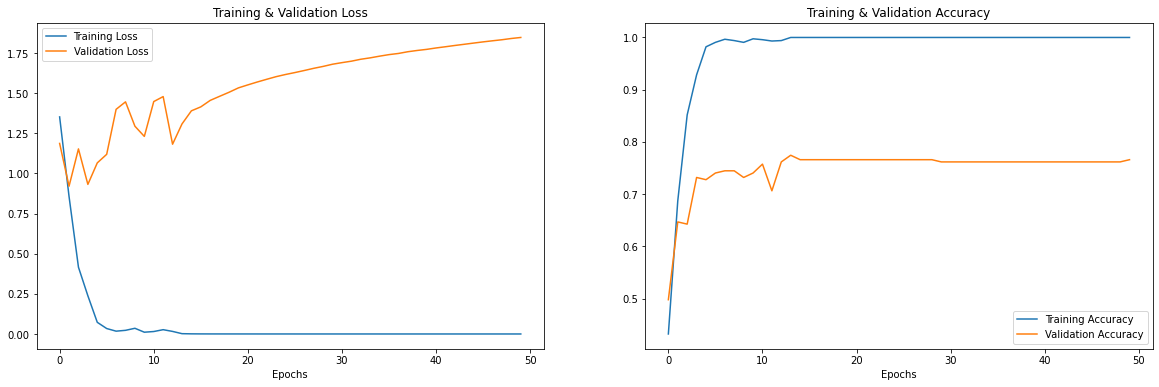

In [ ]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

2/2 [==============================] - 1s 47ms/step


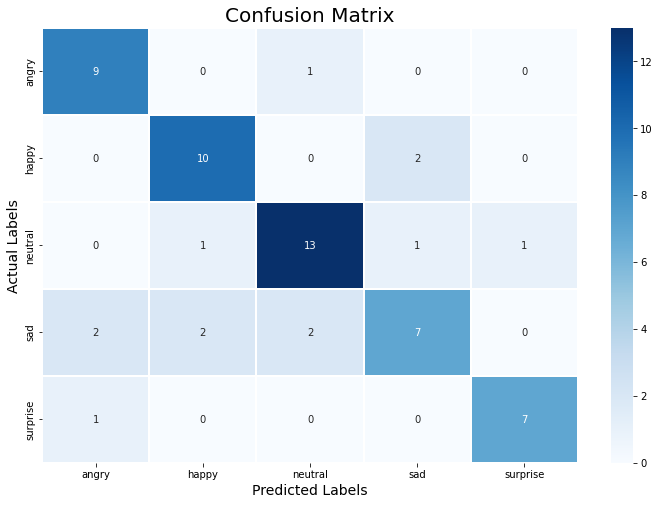

              precision    recall  f1-score   support

       angry       0.75      0.90      0.82        10
       happy       0.77      0.83      0.80        12
     neutral       0.81      0.81      0.81        16
         sad       0.70      0.54      0.61        13
    surprise       0.88      0.88      0.88         8

    accuracy                           0.78        59
   macro avg       0.78      0.79      0.78        59
weighted avg       0.78      0.78      0.77        59



In [ ]:
# predicting on test data.
pred_test = model.predict(X_test)
#pred_test = pred_test.astype(int).flatten()
y_pred = encoder.inverse_transform(pred_test)

#y_test = y_test.astype(int).flatten()
y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 8))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test, y_pred))